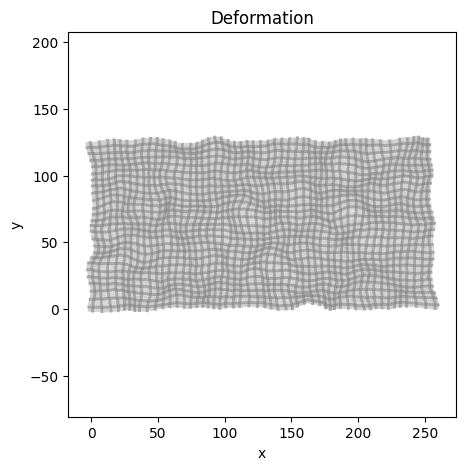

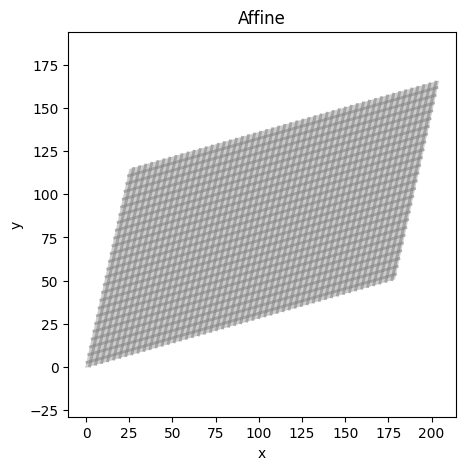

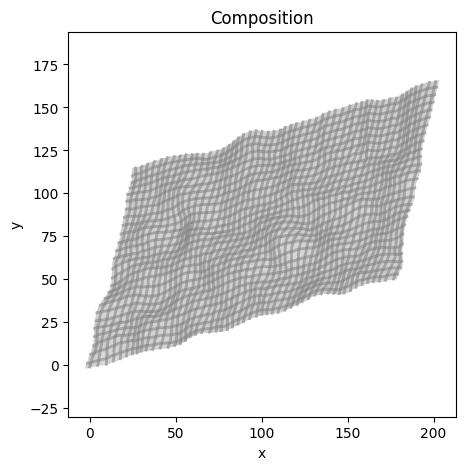

In [1]:
import torch
import matplotlib.pyplot as plt

import composable_mapping as cm
from torchvision.transforms import GaussianBlur

# coordinate_system = cm.CoordinateSystem.centered_normalized(spatial_shape=(256, 256))

coordinate_system = cm.CoordinateSystem.voxel((256, 128)).multiply_world(
    torch.tensor([1, 1], dtype=torch.float32)
)
deformation = cm.samplable_volume(
    GaussianBlur(kernel_size=21, sigma=7.0)(20 * torch.randn(1, 2, 256, 128)),
    coordinate_system=coordinate_system,
    data_format=cm.DataFormat.voxel_displacements(),
)
affine = cm.affine(torch.tensor([[0.7, 0.2, 0.0], [0.2, 0.9, 0.0], [0.0, 0.0, 1.0]]))
composition = deformation @ affine
cm.visualize_as_deformed_grid(deformation)
plt.title("Deformation")
plt.show()
cm.visualize_to_as_deformed_grid(affine, target=coordinate_system)
plt.title("Affine")
plt.show()
cm.visualize_as_deformed_grid(composition)
plt.title("Composition")
plt.show()

In [2]:

# composition = deformation @ affine
print('affine')
print(affine)
print('deformation')
print(deformation)
print('composition')
print(composition)



affine
Affine(transformation=AffineTransformation(transformation_matrix=tensor([[0.7000, 0.2000, 0.0000],
        [0.2000, 0.9000, 0.0000],
        [0.0000, 0.0000, 1.0000]])))
deformation
SamplableVolume(data=MappableTensor(displacements=tensor([[[[-2.1564, -2.2859, -2.0259,  ..., -3.5268, -3.8852, -4.0421],
          [-1.9330, -2.0417, -1.7775,  ..., -3.2731, -3.6345, -3.8091],
          [-1.9573, -2.0677, -1.7965,  ..., -3.3376, -3.6740, -3.8550],
          ...,
          [ 4.6630,  4.6663,  4.7730,  ..., -1.0896, -1.0418, -1.0147],
          [ 4.9234,  4.9207,  5.0320,  ..., -1.3352, -1.3239, -1.2887],
          [ 4.9792,  5.0034,  5.1021,  ..., -1.4556, -1.4648, -1.4542]],

         [[-1.4760, -1.4200, -1.4645,  ..., -2.2646, -2.3332, -2.4615],
          [-1.6427, -1.5619, -1.6356,  ..., -2.0101, -2.0724, -2.1807],
          [-1.6964, -1.5989, -1.6791,  ..., -1.8130, -1.8590, -1.9816],
          ...,
          [ 0.2853,  0.4366,  0.2388,  ...,  0.4190,  0.4750,  0.4991],
         

In [3]:
# composable-mapping demo: multi-resolution dose + fine contour, 2D
# Requires: pip install composable-mapping torch matplotlib

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import composable_mapping as cm


# =========================
# Compatibility helpers
# =========================
def cs_grid(cs):
    """Return CoordinateSystem grid as a MappableTensor (handles property/method)."""
    g = getattr(cs, "grid")
    return g() if callable(g) else g

def cs_shape(cs):
    """Return (H, W[, ...]) regardless of property/method API."""
    s = getattr(cs, "spatial_shape")
    return s() if callable(s) else s

def cs_spacing(cs):
    """Return spacing tensor regardless of property/method API or CPU/GPU variant."""
    f = getattr(cs, "grid_spacing", None) or getattr(cs, "grid_spacing_cpu", None)
    if f is None:
        raise AttributeError("CoordinateSystem has no grid_spacing[ _cpu ] accessor")
    return f() if callable(f) else f

def mt_from_tensor(t, n_channel_dims=1):
    """Create a MappableTensor from a tensor, across versions."""
    if hasattr(cm, "mappable"):
        return cm.mappable(t, n_channel_dims=n_channel_dims)
    # Fallback: older/newer API name
    return cm.MappableTensor.from_tensor(t, n_channel_dims=n_channel_dims)

def get_sampler(name="linear"):
    """Version-safe access to samplers."""
    # Directly instantiate the interpolator classes
    return cm.NearestInterpolator() if name == "nearest" else cm.LinearInterpolator()


# =========================
# Coordinate systems & data
# =========================
def make_coordinate_systems(H=128, W=160, img_spacing_mm=1.0, dose_spacing_mm=0.5):
    """
    Two grids with identical physical FOV:
      - image grid: (H, W), spacing = img_spacing_mm
      - dose  grid: (Hd, Wd), spacing = dose_spacing_mm (denser grid)
    Origin = (0,0), orientation = identity (world in mm).
    """
    img_cs = cm.CoordinateSystem.voxel((H, W)).multiply_world(
        torch.tensor([img_spacing_mm, img_spacing_mm], dtype=torch.float32)
    )
    Hd = int(round(H * img_spacing_mm / dose_spacing_mm))
    Wd = int(round(W * img_spacing_mm / dose_spacing_mm))
    dose_cs = cm.CoordinateSystem.voxel((Hd, Wd)).multiply_world(
        torch.tensor([dose_spacing_mm, dose_spacing_mm], dtype=torch.float32)
    )

    # Optional FOV sanity check
    img_fov = torch.tensor([H * img_spacing_mm, W * img_spacing_mm])
    dose_fov = torch.tensor([Hd * dose_spacing_mm, Wd * dose_spacing_mm])
    if not torch.allclose(img_fov, dose_fov, atol=1e-3):
        print(f"[warn] FOV mismatch: img {img_fov.tolist()} mm vs dose {dose_fov.tolist()} mm")

    return img_cs, dose_cs

def make_synthetic_dose(dose_cs):
    """
    Create a smooth toy 'dose' on the dose grid (same physical FOV as image),
    using world-mm coordinates from the coordinate system.
    """
    gyx_mt = cs_grid(dose_cs)             # MappableTensor of world coords (y,x)
    gyx = gyx_mt.generate_values()        # Materialize -> Tensor
    # Expect shape [..., 2, H, W]
    if gyx.shape[-3] != 2:
        raise RuntimeError(f"Expected coord channels=2 at dim -3, got shape {gyx.shape}")
    y = gyx[..., 0, :, :]
    x = gyx[..., 1, :, :]

    H, W = y.shape[-2:]
    sy, sx = cs_spacing(dose_cs)
    cy, cx = (sy * H) / 2.0, (sx * W) / 2.0

    g1 = torch.exp(-((y - cy) ** 2 + (x - cx) ** 2) / (2.0 * 15.0 ** 2))
    g2 = 0.6 * torch.exp(-((y - 0.35 * 2 * cy) ** 2 + (x - 0.65 * 2 * cx) ** 2) / (2.0 * 10.0 ** 2))
    dose = (g1 + g2).unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    return dose.contiguous()

def make_circle_contour(center_yx_mm, radius_mm, step_mm=0.1):
    """
    Return Nx2 world coordinates (in mm) for a circle with arc-length spacing ~step_mm.
    center_yx_mm: (y, x) in mm
    """
    circumference = 2.0 * math.pi * radius_mm
    n = max(16, int(round(circumference / step_mm)))
    # Older torch doesn't support endpoint=. Emulate [0, 2π) by dropping last point.
    thetas = torch.linspace(0.0, 2.0 * math.pi, n + 1, dtype=torch.float32)[:-1]
    y = center_yx_mm[0] + radius_mm * torch.sin(thetas)
    x = center_yx_mm[1] + radius_mm * torch.cos(thetas)
    return torch.stack([y, x], dim=-1)  # [N, 2] world coords in mm

In [4]:
# Base sizes
H, W = 128, 160
img_cs, dose_cs = make_coordinate_systems(H, W, img_spacing_mm=1.0, dose_spacing_mm=0.5)

# Synthetic high-res dose on its own grid (0.5 mm)
dose = make_synthetic_dose(dose_cs)  # [1,1,Hd,Wd]

In [5]:
print(dose.shape)

print(dose_cs)

torch.Size([1, 1, 1, 256, 320])
CoordinateSystem(spatial_shape=(256, 320), to_voxel_coordinates=HostDiagonalAffineTransformation(definition=DiagonalAffineMatrixDefinition(diagonal=tensor([2., 2.]), translation=None, matrix_shape=torch.Size([3, 3]), dtype=torch.float32, device=cpu)), from_voxel_coordinates=Affine(transformation=HostDiagonalAffineTransformation(definition=DiagonalAffineMatrixDefinition(diagonal=tensor([0.5000, 0.5000]), translation=None, matrix_shape=torch.Size([3, 3]), dtype=torch.float32, device=cpu))))


In [6]:
# print(dose)

dose_image = cm.samplable_volume(
    dose[0,...],
    coordinate_system=dose_cs,
)

deformed_dose_image = dose_image @ composition

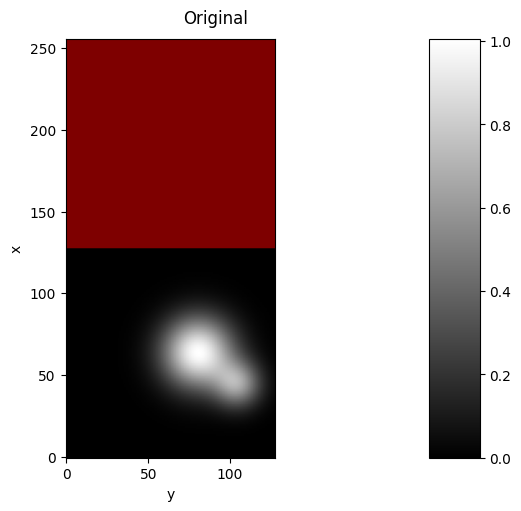

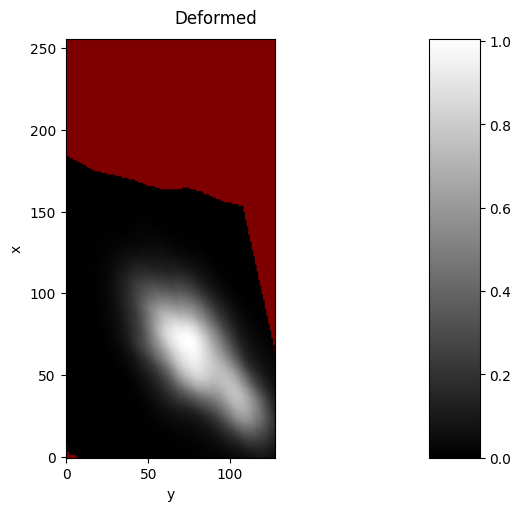

In [10]:
# We flip the coordinates for visualization for the image to show correct size up
visualization_coordinates = coordinate_system.transform_world_with_diagonal_matrix(
    torch.tensor([-1.0, 1.0])
)
fig = cm.visualize_to_as_image(dose_image, target=coordinate_system)
fig.suptitle("Original")
plt.show()
fig = cm.visualize_to_as_image(deformed_dose_image, target=coordinate_system)
fig.suptitle("Deformed")
plt.show()